# Single cell proteogenomic analysis of the cell cycle

## Protein cell cycle clusters

In [11]:
#%% Imports
from SingleCellProteogenomics.utils import *
import SingleCellProteogenomics.utils
import SingleCellProteogenomics.Loaders
import SingleCellProteogenomics.ProteinDataPreparation
import SingleCellProteogenomics.ProteinGaussianClustering
import SingleCellProteogenomics.ProteinVariability
import SingleCellProteogenomics.ProteinBimodality
import SingleCellProteogenomics.ProteinCellCycleDependence
import SingleCellProteogenomics.FucciPseudotime
import SingleCellProteogenomics.RNADataPreparation
import SingleCellProteogenomics.RNACellCycleDependence
import SingleCellProteogenomics.TemporalDelay
import SingleCellProteogenomics.PTMAnalysis
import SingleCellProteogenomics.ProteinStabilityAnalysis
import sklearn.mixture
plt.rcParams['pdf.fonttype'], plt.rcParams['ps.fonttype'], plt.rcParams['savefig.dpi'] = 42, 42, 300 #Make PDF text readable
fucci = SingleCellProteogenomics.FucciCellCycle.FucciCellCycle()

In [12]:
#%% Read in the protein data (methods in ProteinDataPreparation.py)
my_df = ProteinDataPreparation.read_raw_data()
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


reading raw protein IF data
loaded raw data


637104: number of cells before filtering empty wells
636296: number of cells after filtering empty wells
filtering out of focus
636296: number of cells before filtering out of focus images
629997: number of cells after filtering out of focus images
finished filtering
filtering negative staining
629997: number of cells before filtering negative staining from first batch
590511: number of cells after filtering negative staining from first batch
finished filtering
filtering bad fields of view (negative staining, unspecific, etc)
590511: number of cells before filtering out of focus images
521702: number of cells after filtering out of focus images
finished filtering
filtering failed antibodies
521702: number of cells before filtering antibodies failed in HPAv19
505930: number of cells after filtering antibodies failed in HPAv19
finished filtering
filtering mitotic proteins
505930: number of cells before filtering mitotic/microtubule proteins
505335: number of cells after filtering mitotic

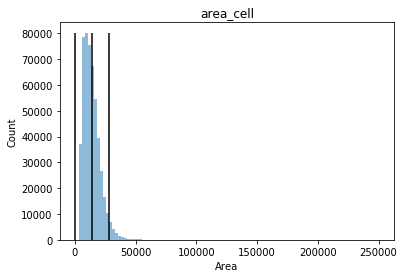

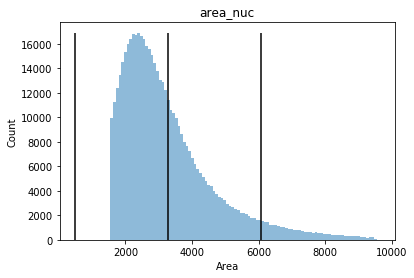

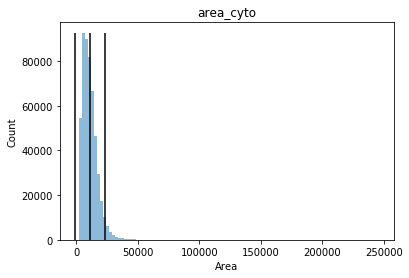

filtering super big nuclei
505335: number of cells before filtering out super big nuclei
477855: number of cells after filtering out super big nuclei
finished filtering on nuclei


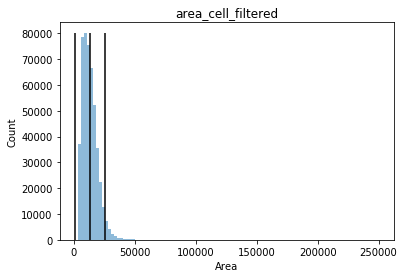

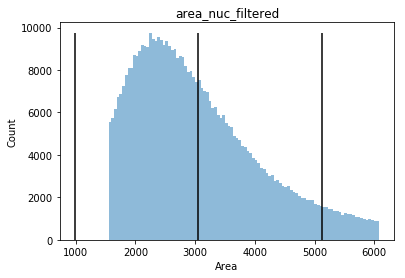

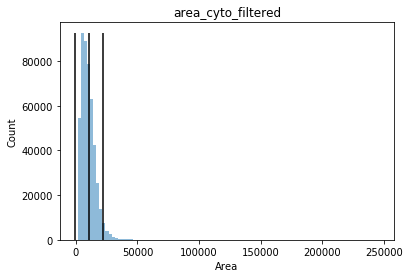

In [ ]:
#%% Idea: Filter the raw data (methods in ProteinDataPreparation.py)
# Execution: Use manual annotations and nucleus size to filter samples and images
# Output: Filtered dataframe
my_df_filtered = ProteinDataPreparation.apply_manual_filtering(my_df, result_dict, ab_dict)
my_df_filtered = ProteinDataPreparation.apply_big_nucleus_filter(my_df_filtered)
my_df_filtered = ProteinDataPreparation.apply_cell_count_filter(my_df_filtered)
my_df_filtered.to_csv("input/processed/python/nuc_predicted_prob_phases_filtered.csv")
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


In [ ]:
#%% Idea: Filter for variation and get compartments (methods in ProteinDataPreparation.py)
# Execution: Use annotated variation and compartment information
# Output: Number of cells filtered
my_df_filtered_variation, my_df_filtered_novariation = ProteinDataPreparation.apply_variation_filter(my_df_filtered, result_dict, my_df)

## Uncomment to output these dataframes (used for skewness / kurtosis analysis)
# my_df_filtered_variation.to_csv("output/nuc_predicted_prob_phases_filtered_variation.csv")
# my_df_filtered_novariation.to_csv("output/nuc_predicted_prob_phases_filtered_novariation.csv")

# filter out the ones missing compartment information; these are localized to mitotic structures and handled differently
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_variation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_variation)

# demonstrate that there are no more missing compartment information
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_compartmentvariation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_compartmentvariation)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


In [ ]:
#%% Idea: Get and process intensities (methods in ProteinDataPreparation.py and ProteinGaussianClustering.py)
# Execution: get intensities; zero center fucci intensities
# Output: Fucci plot
ab_nuc, ab_cyto, ab_cell, mt_cell, green_fucci, red_fucci = ProteinDataPreparation.read_sample_data(my_df_filtered_compartmentvariation)
log_green_fucci, log_red_fucci, log_green_fucci_zeroc, log_red_fucci_zeroc, log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale, fucci_data = ProteinGaussianClustering.zero_center_fucci(green_fucci, red_fucci, u_plate, well_plate, plate)
    
plt.hist2d(log_green_fucci_zeroc_rescale,log_red_fucci_zeroc_rescale,bins=200)
plt.xlabel("Log10 Green Fucci Intensity")
plt.ylabel("Log10 Red Fucci Intensity")
plt.savefig("figures/FucciPlotProteinIFData_unfiltered.png")
plt.show()
plt.close()

# General picture of antibody intensity density
sbn.distplot(ab_cell, hist=False)
plt.xlabel("Mean Intensity")
plt.ylabel("Density")
plt.savefig("figures/antibody_cell_intensity.pdf")
plt.show()
plt.close()


In [ ]:
#%% Idea: Gaussian clustering per plate to identify G1/S/G2 and do kruskal test for variance
# Exec: sklearn.mixture.GaussianMixture & scipy.stats.kruskal
# Output: FDR for cell cycle variation per well per compartment
cluster_labels = ProteinGaussianClustering.gaussian_clustering(log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale)

# NB! The cluster labels can change if any prior analysis changes. Inspect the plots so that top-left FUCCI cluster is G1, top-right is S, bottom-right is G2.
g1, sph, g2 = cluster_labels == 2, cluster_labels == 1, cluster_labels == 0
alpha_gauss, doGenerateBoxplotsPerGene = 0.05, True
wp_comp_kruskal_gaussccd_adj, wp_pass_kruskal_gaussccd_bh_comp, wp_mt_kruskal_gaussccd_adj, wp_pass_gaussccd_bh_mt =  ProteinGaussianClustering.gaussian_clustering_analysis(alpha_gauss, doGenerateBoxplotsPerGene, g1, sph, g2, wp_ensg, well_plate, u_well_plates, ab_cell, ab_nuc, ab_cyto, mt_cell, wp_iscell, wp_isnuc, wp_iscyto)

# General look at replicates in mock-bulk analysis
ProteinGaussianClustering.address_replicates(alpha_gauss, wp_pass_kruskal_gaussccd_bh_comp, wp_ensg, wp_ab, u_well_plates)

 ## Protein FUCCI pseudotime

In [ ]:
#%% Read in the protein data
import_dict = Loaders.load_protein_fucci_pseudotime()
u_plate, well_plate, well_plate_imgnb, u_well_plates = import_dict["u_plate"], import_dict["well_plate"], import_dict["well_plate_imgnb"], import_dict["u_well_plates"]
ab_nuc, ab_cyto, ab_cell, mt_cell = import_dict["ab_nuc"], import_dict["ab_cyto"], import_dict["ab_cell"], import_dict["mt_cell"]
area_cell, area_nuc =  import_dict["area_cell"], import_dict["area_nuc"]
wp_ensg, wp_ab = import_dict["wp_ensg"], import_dict["wp_ab"]
green_fucci, red_fucci = import_dict["green_fucci"], import_dict["red_fucci"]
log_green_fucci_zeroc, log_red_fucci_zeroc = import_dict["log_green_fucci_zeroc"], import_dict["log_red_fucci_zeroc"]
log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale = import_dict["log_green_fucci_zeroc_rescale"], import_dict["log_red_fucci_zeroc_rescale"]
wp_comp_kruskal_gaussccd_adj, wp_pass_kruskal_gaussccd_bh_comp = import_dict["wp_comp_kruskal_gaussccd_adj"], import_dict["wp_pass_kruskal_gaussccd_bh_comp"]
fucci_data = import_dict["fucci_data"]
wp_iscell, wp_isnuc, wp_iscyto = import_dict["wp_iscell"], import_dict["wp_isnuc"], import_dict["wp_iscyto"]


In [ ]:
#%% 
# Idea: Calculate the polar coordinates and other stuff
# Exec: Devin's calculations
# Output: fucci plot with polar coordinates

pseudotime_result = FucciPseudotime.pseudotime_protein(fucci_data, 
                           ab_nuc,ab_cyto,ab_cell,mt_cell,area_cell, area_nuc,
                           well_plate,well_plate_imgnb, log_red_fucci_zeroc_rescale,log_green_fucci_zeroc_rescale)
pol_sort_well_plate, pol_sort_norm_rev, pol_sort_well_plate_imgnb, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_ab_cell, pol_sort_mt_cell, pol_sort_area_cell, pol_sort_area_nuc, pol_sort_fred, pol_sort_fgreen = pseudotime_result


In [ ]:
#%% Calculate measures of variance of protein abundance in single cells
# Idea: Calculate measures of variance, and show them in plots
# Execution: Now that we already have the data filtered for variability, this is just descriptive.
# Output: scatters of antibody vs microtubule variances by different measures of variaibility

use_log = False # toggle for using log-transformed intensities; we decided to use natural intensities
calculate_variaton_result = ProteinVariability.calculate_variation(use_log, u_well_plates, wp_iscell, wp_isnuc, wp_iscyto, 
                                                pol_sort_well_plate, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell, pol_sort_well_plate_imgnb)
mean_mean_comp, var_comp, gini_comp, cv_comp, var_cell, gini_cell, cv_cell, var_mt, gini_mt, cv_mt = calculate_variaton_result

# Compare variances for protein and microtubules, the internal control for each image
general_boxplot((var_comp, var_mt), ("Protein", "Microtubules"), "", "Variance", "", False, f"figures/ProteinMicrotubuleVariances.pdf")
general_boxplot((cv_comp, gini_mt), ("Protein", "Microtubules"), "", "CV", "", False, f"figures/ProteinMicrotubuleCVs.pdf")
general_boxplot((gini_comp, gini_mt), ("Protein", "Microtubules"), "", "Gini", "", False, f"figures/ProteinMicrotubuleGinis.pdf")
print(f"{scipy.stats.kruskal(var_comp, var_mt)[1]}: p-value for difference between protein and microtubule variances")
print(f"{scipy.stats.kruskal(cv_comp, gini_mt)[1]}: p-value for difference between protein and microtubule CVs")
print(f"{scipy.stats.kruskal(gini_comp, gini_mt)[1]}: p-value for difference between protein and microtubule Gini indices")


In [ ]:
#%% Gaussian clustering to identify biomodal intensity distributions
bimodal_results = ProteinBimodality.identify_bimodal_intensity_distributions(u_well_plates, wp_ensg,
             pol_sort_well_plate, pol_sort_norm_rev, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell,
             wp_iscell, wp_isnuc, wp_iscyto)
wp_isbimodal_fcpadj_pass, wp_bimodal_cluster_idxs, wp_isbimodal_generally, wp_bimodal_fcmaxmin = bimodal_results

In [ ]:
#%% Determine cell cycle dependence for each protein
use_log_ccd = False
do_remove_outliers = True
alphaa = 0.05

# Determine cell cycle dependence for proteins
ccd_results = CellCycleDependence.cell_cycle_dependence_protein(
        u_well_plates, wp_ensg, use_log_ccd, do_remove_outliers,
        pol_sort_well_plate, pol_sort_norm_rev, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell,
        pol_sort_area_cell, pol_sort_area_nuc,
        wp_iscell, wp_isnuc, wp_iscyto,
        wp_isbimodal_fcpadj_pass, wp_bimodal_cluster_idxs, wp_comp_kruskal_gaussccd_adj)
wp_comp_ccd_difffromrng, wp_comp_ccd_clust1, wp_comp_ccd_clust2, wp_ccd_unibimodal, wp_comp_ccd_gauss, perc_var_comp, mean_diff_from_rng, wp_comp_eq_percvar_adj, mean_diff_from_rng_clust1, wp_comp_eq_percvar_adj_clust1, mean_diff_from_rng_clust2, wp_comp_eq_percvar_adj_clust2, folder = ccd_results

# Move the temporal average plots to more informative places
CellCycleDependence.copy_mvavg_plots_protein(folder, wp_ensg, wp_comp_ccd_difffromrng, wp_isbimodal_fcpadj_pass, wp_comp_ccd_clust1, wp_comp_ccd_clust2, wp_ccd_unibimodal, wp_comp_ccd_gauss)
CellCycleDependence.global_plots_protein(alphaa, u_well_plates, wp_ccd_unibimodal, perc_var_comp, mean_mean_comp, gini_comp, cv_comp, mean_diff_from_rng, wp_comp_eq_percvar_adj, wp_comp_kruskal_gaussccd_adj)
CellCycleDependence.analyze_ccd_variation_protein(
    folder, u_well_plates, wp_ensg, wp_ab, wp_iscell, wp_isnuc, wp_iscyto,
    wp_comp_ccd_difffromrng, wp_comp_ccd_clust1, wp_comp_ccd_clust2, 
    var_comp, gini_comp, 
    mean_diff_from_rng, wp_comp_kruskal_gaussccd_adj, wp_comp_eq_percvar_adj, 
    mean_diff_from_rng_clust1, wp_comp_eq_percvar_adj_clust1, mean_diff_from_rng_clust2, wp_comp_eq_percvar_adj_clust2,
    wp_isbimodal_fcpadj_pass, wp_isbimodal_generally, wp_ccd_unibimodal, wp_bimodal_fcmaxmin, wp_comp_ccd_gauss)

## RNA FUCCI Pseudotime

In [ ]:
bioccd = np.genfromtxt("input/processed/manual/biologically_defined_ccd.txt", dtype='str') # from mitotic structures
wp_ensg = np.load("output/pickles/wp_ensg.npy", allow_pickle=True)
ccd_comp = np.load("output/pickles/ccd_comp.npy", allow_pickle=True)
nonccd_comp = np.load("output/pickles/nonccd_comp.npy", allow_pickle=True)

In [ ]:
#%% Convert FACS intensities for FUCCI markers to pseudotime using the same polar coordinate methods as for protein
# Idea: Use the polar coordinate pseudotime calculations to calculate the pseudotime for each cell
# Execution: Adapt Devin's code for the cells sorted for RNA-Seq
# Output: Make log-log fucci intensity plots for the cells analyzed by RNA-Seq; Plot of all fucci pseudotimes; table of pseudotimes for each cell
adata, phases_filt = RNADataPreparation.read_counts_and_phases("All", "Counts", False, "protein_coding") # no qc, yet
FucciPseudotime.pseudotime_rna(adata, phases_filt)

In [ ]:
#%% Single cell RNA-Seq data preparation and general analysis
RNADataPreparation.general_plots()
RNADataPreparation.analyze_noncycling_cells()


In [ ]:
#%% Idea: Similar to mock-bulk analysis for proteins, we can evaluate each gene bundled by phase across cells
# Execution: Make boxplots of RNA expression by phase
# Output: boxplots for each gene
plate, valuetype, use_spikeins, biotype_to_use = "All", "Tpms", False, "protein_coding"
adata, phases = RNADataPreparation.read_counts_and_phases(plate, valuetype, use_spikeins, biotype_to_use)
adata, phasesfilt = RNADataPreparation.qc_filtering(adata, do_log_normalize=True, do_remove_blob=True)
g1, s, g2 = adata.obs["phase"] == "G1", adata.obs["phase"] == "S-ph", adata.obs["phase"] == "G2M"
do_make_boxplots = False
if do_make_boxplots:
    for iii, ensg in enumerate(adata.var_names):
        maxtpm = np.max(np.concatenate((adata.X[g1,iii], adata.X[s,iii], adata.X[g2,iii])))
        RNACellCycleDependence.boxplot_result(adata.X[g1,iii] / maxtpm, adata.X[s,iii] / maxtpm, adata.X[g2,iii] / maxtpm, "figures/RNABoxplotByPhase", ensg)


In [ ]:
#%% Idea: Display general RNA expression patterns in single cells using UMAP dimensionality reduction, and display with FUCCI pseudotime overlayed
FucciPseudotime.pseudotime_umap(adata) # Generate a UMAP with the pseudotime overlayed

# We can also show that the cycle pattern remains when the curated CCD genes or CCD proteins are removed,
# demonstrating that there's still valuable information about cell cycling beyond what was called CCD
RNADataPreparation.demonstrate_umap_cycle_without_ccd(adata)

# Read in the currated CCD genes / CCD proteins from the present work / Non-CCD genes from the present work; filter for genes that weren't filtered in QC of RNA-Seq
bioccd = np.genfromtxt("input/processed/manual/biologically_defined_ccd.txt", dtype='str') # from mitotic structures in the protein work
ccd_regev_filtered, ccd_filtered, nonccd_filtered = RNADataPreparation.ccd_gene_lists(adata)
adata_ccdprotein, adata_nonccdprotein, adata_regevccdgenes = RNADataPreparation.is_ccd(adata, wp_ensg, ccd_comp, nonccd_comp, bioccd, ccd_regev_filtered)

# Generate plots with expression of genes overlayed
do_make_gene_expression_plots = False
expression_data = adata.X
normalized_exp_data = (expression_data.T / np.max(expression_data, axis=0)[:,None]).T
if do_make_gene_expression_plots:
    # UMAPs with RNA expression overlayed
    RNACellCycleDependence.plot_expression_umap(adata, ccd_regev_filtered, "figures/RegevGeneExpressionUmap") # curated CCD genes from a different scRNA-Seq analysis
    RNACellCycleDependence.plot_expression_umap(adata, ccd_filtered, "figures/CcdGeneExpressionUmap") # CCD proteins from the present immunofluorescense work
    RNACellCycleDependence.plot_expression_umap(adata, nonccd_filtered, "figures/NonCcdGeneExpressionUmap") # non-CCD proteins from the present immunofluorescense work

    # Log-log FUCCI plot with RNA expression overlayed
    RNACellCycleDependence.plot_expression_facs(ccd_regev_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/RegevGeneFucci")
    RNACellCycleDependence.plot_expression_facs(ccd_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/CcdGeneFucci")
    RNACellCycleDependence.plot_expression_facs(nonccd_filtered, normalized_exp_data, phasesfilt, adata.var_names, "figures/NonCcdGeneFucci")

# Cluster the expression into phases and analyze it that way
bulk_phase_tests = RNACellCycleDependence.analyze_ccd_variation_by_phase_rna(adata, normalized_exp_data, biotype_to_use)
if do_make_gene_expression_plots:
     # Remove?
    RNACellCycleDependence.plot_expression_boxplots(adata, ccd_regev_filtered, bulk_phase_tests, "figures/RegevGeneBoxplots")
    RNACellCycleDependence.plot_expression_boxplots(adata, ccd_filtered, bulk_phase_tests, "figures/CcdGeneBoxplots")
    RNACellCycleDependence.plot_expression_boxplots(adata, nonccd_filtered, bulk_phase_tests, "figures/NonCcdGeneBoxplots")

In [ ]:
#%% Moving average calculations and randomization analysis for RNA
rna_ccd_analysis_results = RNACellCycleDependence.analyze_ccd_variation_by_mvavg_rna(adata, wp_ensg, ccd_comp, bioccd, adata_nonccdprotein, adata_regevccdgenes, biotype_to_use)
percent_ccd_variance, total_gini, mean_diff_from_rng, pass_meandiff, eq_percvar_adj, fucci_time_inds, norm_exp_sort, moving_averages, mvavg_xvals, perms = rna_ccd_analysis_results

RNACellCycleDependence.figures_ccd_analysis_rna(adata, percent_ccd_variance, mean_diff_from_rng, pass_meandiff, eq_percvar_adj, wp_ensg, ccd_comp, ccd_regev_filtered)
RNACellCycleDependence.mvavg_plots_pergene(adata, fucci_time_inds, norm_exp_sort, moving_averages, mvavg_xvals)
RNACellCycleDependence.plot_overall_and_ccd_variances(adata, biotype_to_use, total_gini, percent_ccd_variance, pass_meandiff, adata_ccdprotein, adata_nonccdprotein, adata_regevccdgenes)



In [ ]:
#%% Moving average calculations and randomization analysis for the spike-in internal controls
adata_spikeins, phases_spikeins = RNADataPreparation.read_counts_and_phases(plate, valuetype, use_spike_ins=True, biotype_to_use="")
sc.pp.filter_genes(adata_spikeins, min_cells=100)
print(f"data shape after filtering: {adata_spikeins.X.shape}")

RNACellCycleDependence.ccd_analysis_of_spikeins(adata_spikeins, perms)

## Temporal delay of peak protein and RNA expression

In [ ]:
#%% Read in the protein data
import_dict = Loaders.load_temporal_delay()
u_well_plates, wp_ensg = import_dict["u_well_plates"], import_dict["wp_ensg"]
wp_iscell, wp_isnuc, wp_iscyto = import_dict["wp_iscell"], import_dict["wp_isnuc"], import_dict["wp_iscyto"]
ccd_comp, ccdtranscript = import_dict["ccd_comp"], import_dict["ccdtranscript"] 
pol_sort_well_plate, pol_sort_norm_rev = import_dict["pol_sort_well_plate"], import_dict["pol_sort_norm_rev"]
pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_ab_cell, pol_sort_mt_cell = import_dict["pol_sort_ab_nuc"], import_dict["pol_sort_ab_cyto"], import_dict["pol_sort_ab_cell"], import_dict["pol_sort_mt_cell"]
var_comp_prot, gini_comp_prot, cv_comp_prot = import_dict["var_comp"], import_dict["gini_comp"], import_dict["cv_comp"]
var_cell_prot, gini_cell_prot, cv_cell_prot = import_dict["var_cell"], import_dict["gini_cell"], import_dict["cv_cell"]

In [ ]:
#%% Idea: Make temporal heatmap for peak protein expression, and compare known and novel proteins that peak at similar times
# Execution: plt.imshow makes a heatmap if given a 2D array
# Output: heatmap; correlations of known/novel proteins
highlights = []#'ORC6','DUSP19','BUB1B','DPH2', 'FLI1']
highlights_ensg = []#'ORC6','DUSP19','BUB1B','DPH2', 'FLI1']

protein_heatmap_results = TemporalDelay.protein_heatmap(highlights, highlights_ensg, 
    ccd_comp, u_well_plates, wp_ensg, pol_sort_norm_rev, pol_sort_well_plate, pol_sort_ab_cell, pol_sort_ab_nuc, pol_sort_ab_cyto, pol_sort_mt_cell, wp_iscell, wp_isnuc, wp_iscyto)
sorted_maxpol_array, wp_binned_values, wp_max_pol, wp_max_pol_ccd, xvals = protein_heatmap_results

# Correlations of known and novel proteins that peak at similar times
TemporalDelay.peak_expression_correlation_analysis(wp_binned_values, wp_max_pol, wp_ensg, pol_sort_well_plate, u_well_plates)


In [ ]:
#%% Create a heatmap of peak RNA expression
highlight_names, highlight_ensg = [],[]
adata, sorted_max_moving_avg_pol_ccd, norm_exp_sort, max_moving_avg_pol = TemporalDelay.rna_heatmap(highlight_names, highlight_ensg, ccdtranscript, xvals)


In [ ]:
#%% Compare the variances and time of peak expression between protein and RNA
TemporalDelay.compare_variances_prot_v_rna(adata, norm_exp_sort, wp_ensg, var_comp_prot, gini_comp_prot, cv_comp_prot, var_cell_prot, gini_cell_prot, cv_cell_prot)
TemporalDelay.compare_peak_expression_prot_v_rna(adata, wp_ensg, ccd_comp, ccdtranscript, wp_max_pol, wp_max_pol_ccd, sorted_maxpol_array, max_moving_avg_pol, sorted_max_moving_avg_pol_ccd)


## Protein PTM analysis using PTM site occupancies

In [ ]:
#%% Import the genes names we're analyzing
# Read in RNA-Seq data again and the CCD gene lists
plate, valuetype, use_spikeins, biotype_to_use = "All", "Tpms", False, "protein_coding"
adata, phases = RNADataPreparation.read_counts_and_phases(plate, valuetype, use_spikeins, biotype_to_use)
adata, phasesfilt = RNADataPreparation.qc_filtering(adata, do_log_normalize= True, do_remove_blob=True)

import_dict = Loaders.load_ptm_and_stability(adata)
wp_ensg, wp_max_pol = import_dict["wp_ensg"], import_dict["wp_max_pol"]
ccdtranscript, nonccdtranscript = import_dict["ccdtranscript_names"], import_dict["nonccdtranscript_names"]
ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated = import_dict["ccdprotein_transcript_regulated_names"], import_dict["ccdprotein_nontranscript_regulated_names"]
genes_analyzed = import_dict["genes_analyzed_names"]
ccd_regev_filtered, ccd_filtered = import_dict["ccd_regev_filtered_names"], import_dict["ccd_filtered_names"] 
ccdprotein, nonccdprotein = import_dict["ccdprotein_names"], import_dict["nonccdprotein_names"]
utils.save_gene_names_by_category(adata) # We're using gene names for this analysis instead of ENSG gene identifiers, so save those gene names


In [ ]:
#%% Analyze the PTMs from bulk U2OS data and see if they are more expressed
# one or the other
# Idea: PTM annotation counts are pretty biased; PTM data might be better
# Execution: 
#   Take in the results from analyzing U2OS data with MetaMorpheus.
#   Count mods for each protein, excluding oxidations
# Output: # of PTMs per protein in each class and for all proteins

# Read in MetaMorpheus results
genemodsBulk = PTMAnalysis.analyze_ptms("input/raw/U2OSBulkAllProteinGroups.tsv", ccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, genes_analyzed)
genemodsPhospho = PTMAnalysis.analyze_ptms("input/raw/U2OSPhosphoAllProteinGroups.tsv", ccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, genes_analyzed)

# Analyze the modification occupancy for each PTM site
dfBulk, occdfBulk = PTMAnalysis.process_genemods(genemodsBulk)
dfPhospho, occdfPhospho = PTMAnalysis.process_genemods(genemodsPhospho)

# Investigate whether PTM occupancies have correlations with cell division pseudotime (they don't with this dataset)
PTMAnalysis.temporal_ptm_regulation_not_observed(dfBulk, occdfBulk, "Bulk", wp_max_pol, wp_ensg, ccdprotein)
PTMAnalysis.temporal_ptm_regulation_not_observed(dfPhospho, occdfPhospho, "Phospho", wp_max_pol, wp_ensg, ccdprotein)

# Compare the PTM regulation using PTM site occupancies between transcript and non-transcript regulated groups
PTMAnalysis.compare_ptm_regulation(dfBulk, occdfBulk, "Bulk", genes_analyzed, ccd_regev_filtered, ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, ccdprotein, nonccdprotein)
PTMAnalysis.compare_ptm_regulation(dfPhospho, occdfPhospho, "Phospho", genes_analyzed, ccd_regev_filtered, ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, ccdprotein, nonccdprotein)


## Protein stability analysis using MS proteomic melting point data

In [ ]:
#%% Perform melting point analysis
# Idea: A lower melting point for a protein indicates a higher propensity to unfold, 
#    and so the melting points measured by MS proteomics serve as a useful way to study the protein stability of CCD proteins
# Output: Boxplots illustrating differences in stability for different classes of CCD proteins
ProteinStabilityAnalysis.melting_point_analysis(ccdtranscript, nonccdtranscript, ccdprotein_transcript_regulated, ccdprotein_nontranscript_regulated, nonccdprotein)
